# Cost-Index-Vs-Min-Wage

## Install Dependencies

In [3]:
! pip3 install requests beautifulsoup4 pandas matplotlib numpy

## Scrape Min Wage Data 

In [ ]:
'''Extracts Minimum wage data from https://www.dol.gov/agencies/whd/state/minimum-wage/history and stores it into csv file'''
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Send a GET request to the webpage
url = "https://www.dol.gov/agencies/whd/state/minimum-wage/history"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content of the webpage
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all tables containing the minimum wage data
    tables = soup.find_all('table')

    # Initialize an empty DataFrame to store the combined data
    combined_df = pd.DataFrame()

    # Iterate through each table
    for table in tables:
        # Extract data from the table
        data = []
        for row in table.find_all('tr'):
            # Extract data from each row
            row_data = [cell.text.strip() for cell in row.find_all('td')]
            if row_data:
                data.append(row_data)

        # Extract headers from the first row
        headers = [header.text.strip() for header in table.find('tr').find_all('th')]

        # Create DataFrame
        df = pd.DataFrame(data, columns=headers)

        # Merge with combined DataFrame based on 'State or other jurisdiction' column
        if not combined_df.empty:
            combined_df = pd.merge(combined_df, df, on='State or otherjurisdiction', how='outer')
        else:
            combined_df = df

    # Save the combined DataFrame as a CSV file
    combined_df.to_csv('public/data/minimum_wage_data.csv', index=False)

    # Print the combined DataFrame
    print(combined_df)
else:
    print("Failed to retrieve data from the webpage.")



## Clean Min Wage Data

In [61]:
import pandas as pd
import re

# Read the data into a DataFrame
data = pd.read_csv('public/data/minimum_wage_data.csv')

# Remove dollar sign ('$') from all columns
data = data.replace({'\$': ''}, regex=True)

# Remove parentheses and everything inside them
data = data.replace({'\([^)]*\)': ''}, regex=True)

# Function to find the average for values with ranges and keep everything after the second number
def find_average_and_keep_remainder(value):
    # Check if the value is a string
    if isinstance(value, str):
        # Extract the numbers and remainder from the value
        numbers = re.findall(r'(\d+\.\d+)(?:\s*-\s*(\d+\.\d+))?(.*)', value)
        # If no numbers are found, return None
        if not numbers:
            return None
        # If there are numbers, extract them and the remainder
        number1, number2, remainder = numbers[0]
        # If there's only one number, return it with the remainder
        if not number2:
            return float(number1)
        # If there's a range, calculate the average and append the remainder
        avg = (float(number1) + float(number2)) / 2
        return f"{avg}{remainder}"
    else:
        # Return the input value if it's not a string
        return value

# Apply the function to all columns except the first one
data[data.columns[1:]] = data[data.columns[1:]].applymap(find_average_and_keep_remainder)


# Define conversion factors
hours_per_week = 40
hours_per_day = 8

# Function to convert per week to hourly rate
def per_week_to_hourly(value):
    if isinstance(value, float):
        return value  # No conversion needed for float values
    else:
        value = value.replace('/wk', '')
        return float(value) / hours_per_week

# Function to convert per day to hourly rate
def per_day_to_hourly(value):
    value = value.replace('/day', '')
    return value / hours_per_day

for index, row in data.iterrows():
    # Iterate over each column in the row
    for col_name in data.columns[1:]:
        # Check if the value is a string and if '/wk' is in the value
        if isinstance(row[col_name], str) and '/wk' in row[col_name]:
            # Apply the conversion function for per week to hourly rate
            data.at[index, col_name] = per_week_to_hourly(row[col_name])
        # Check if the value is a string and if '/day' is in the value
        elif isinstance(row[col_name], str) and '/day' in row[col_name]:
            # Apply the conversion function for per day to hourly rate
            data.at[index, col_name] = per_day_to_hourly(row[col_name])

data.to_csv('public/data/clean_min_wage_data.csv', index=False)

# Now the data should contain the Arizona data properly
print(data)


   State or otherjurisdiction 1968 (a)            1970 (a)  \
0                    Federal      1.15                 1.3   
1                     Alabama     None                None   
2                      Alaska      2.1                 2.1   
3                     Arizona    0.564               0.564   
4                    Arkansas     1.25                 1.1   
5                  California     1.65                1.65   
6                    Colorado    1.125               1.125   
7                 Connecticut      1.4                 1.6   
8                    Delaware     1.25                1.25   
9                     Florida     None                None   
10                    Georgia     None                None   
11                     Hawaii     1.25                 1.6   
12                      Idaho     1.15                1.25   
13                   Illinois     None                None   
14                    Indiana     1.15                1.25   
15      

## Graph Clean Min Wage Data

<Figure size 1000x600 with 0 Axes>

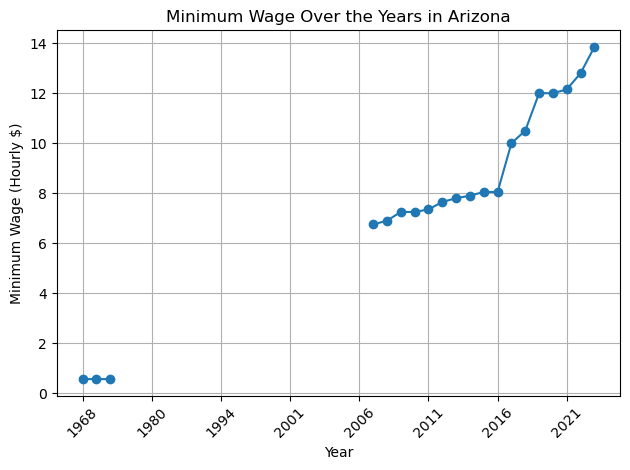

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def plot_min_wage_by_state(state_name, data_file='public/data/clean_min_wage_data.csv'):
    # Read the cleaned data from the CSV file
    data = pd.read_csv(data_file)

    # Drop rows where there is no minimum wage data
    data = data.dropna(subset=data.columns[1:], how='all')

    # Check if the state exists in the data
    if state_name not in data['State or otherjurisdiction'].values:
        print(f"No data found for {state_name}.")
        return

    # Extract data for the specified state
    state_data = data[data['State or otherjurisdiction'] == state_name].iloc[:, 1:]

    # Plot the minimum wage over the years for the specified state
    plt.figure(figsize=(10, 6))
    state_data.T.plot(legend=False, marker='o', linestyle='-')
    plt.title(f'Minimum Wage Over the Years in {state_name}')
    plt.xlabel('Year')
    plt.ylabel('Minimum Wage (Hourly $)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_min_wage_by_state('Arizona')


## Clean Cost-Index Data

In [76]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
data = pd.read_csv("public/data/cost_index_data.csv")

# Filter rows where the indicator is "Cost of Living Index"
cost_of_living_data = data[data['indicator'] == 'Cost of Living Index']

# Extract location, date, and value columns
location = cost_of_living_data['location']
date = cost_of_living_data['Date']
value = cost_of_living_data['Value']

# Create a new DataFrame with extracted data
clean_data = pd.DataFrame({
    'Location': location,
    'Date': date,
    'Value': value
})
clean_data = clean_data[~clean_data['Date'].str.contains('Q')]

# Save the clean data to a new CSV file
clean_data.to_csv("public/data/clean_cost_index_data.csv", index=False)


## Graph Clean Cost Index Data

/var/folders/8q/1hs5pwm55k7_wwy4xc5xkd140000gn/T/ipykernel_89814/728129353.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['Date'] = location_data['Date'].astype(int)


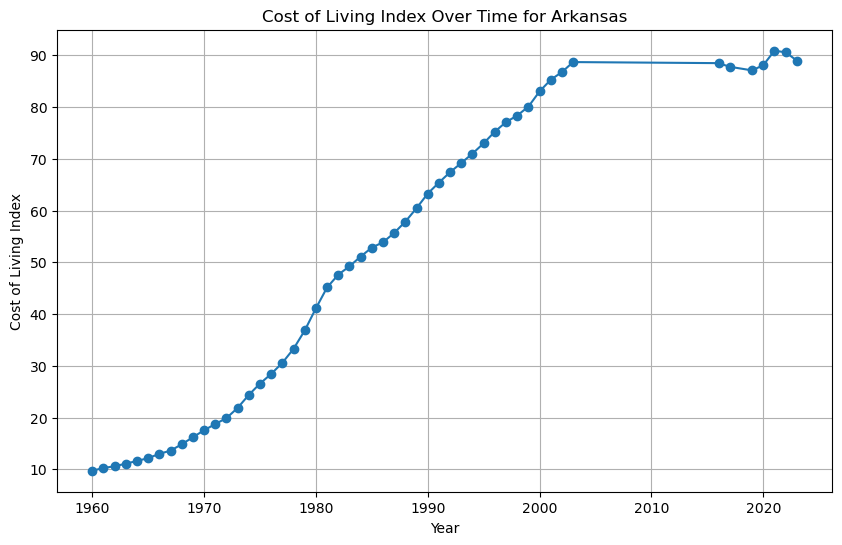

In [91]:
import pandas as pd
import matplotlib.pyplot as plt

def graph_cost_of_living_by_year(location):
    # Read the cleaned CSV file
    clean_data = pd.read_csv("public/data/clean_cost_index_data.csv")

    # Filter data for the specified location
    location_data = clean_data[clean_data['Location'] == location]

    # Convert 'Date' column to integer
    location_data['Date'] = location_data['Date'].astype(int)

    # Group data by year and calculate the mean cost of living index for each year
    yearly_data = location_data.groupby('Date')['Value'].mean()

    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_data.index, yearly_data.values, marker='o', linestyle='-')
    plt.title(f"Cost of Living Index Over Time for {location}")
    plt.xlabel("Year")
    plt.ylabel("Cost of Living Index")
    plt.grid(True)
    plt.show()

# Example usage
graph_cost_of_living_by_year("Arkansas")



## Comparison Graph for Cost of Living and Min Wage

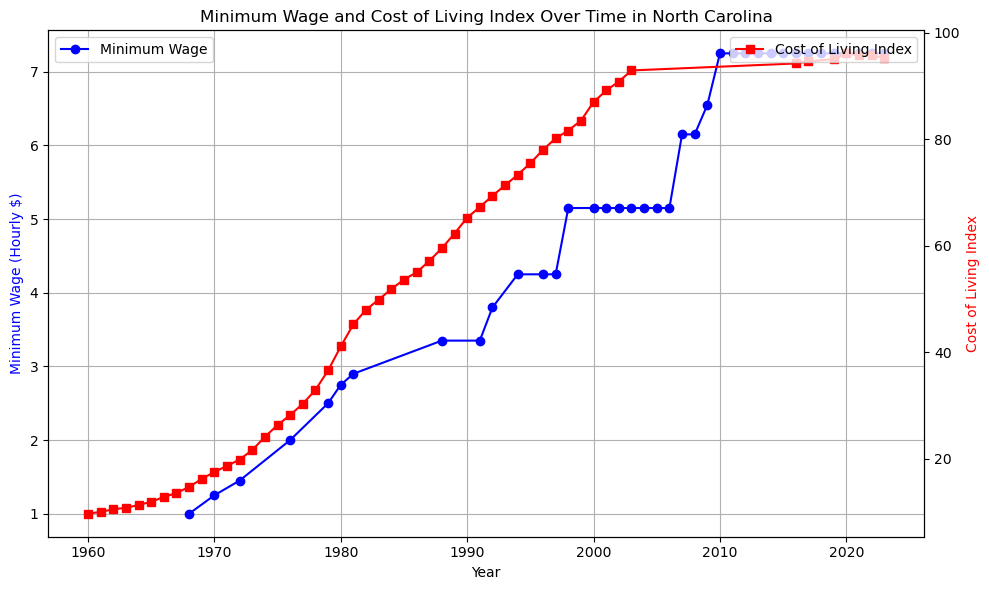

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_min_wage_and_cost_of_living(location):
    # Read the cleaned minimum wage data from the CSV file
    min_wage_data = pd.read_csv("public/data/clean_min_wage_data.csv")

    # Drop rows where there is no minimum wage data
    min_wage_data = min_wage_data.dropna(subset=min_wage_data.columns[1:], how='all')

    # Check if the state exists in the data
    if location not in min_wage_data['State or otherjurisdiction'].values:
        print(f"No minimum wage data found for {location}.")
        return

    # Extract minimum wage data for the specified location
    min_wage_state_data = min_wage_data[min_wage_data['State or otherjurisdiction'] == location].iloc[:, 1:]

    # Read the cleaned cost of living index data from the CSV file
    cost_of_living_data = pd.read_csv("public/data/clean_cost_index_data.csv")

    # Filter data for the specified location
    location_data = cost_of_living_data[cost_of_living_data['Location'] == location]

    # Convert 'Date' column to integer
    location_data.loc[:, 'Date'] = location_data['Date'].astype(int)

    # Plot both minimum wage and cost of living index on the same graph
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot minimum wage data
    ax1.plot(min_wage_state_data.columns.astype(int), min_wage_state_data.values.flatten(), color='b', marker='o', linestyle='-', label='Minimum Wage')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Minimum Wage (Hourly $)', color='b')

    # Plot cost of living index
    ax2 = ax1.twinx()
    ax2.plot(location_data['Date'], location_data['Value'], color='r', marker='s', linestyle='-', label='Cost of Living Index')
    ax2.set_ylabel('Cost of Living Index', color='r')

    # Set title and grid
    plt.title(f'Minimum Wage and Cost of Living Index Over Time in {location}')
    ax1.grid(True)

    # Show legend
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Example usage
plot_min_wage_and_cost_of_living("North Carolina")

